# Get local object tilts

 Chia-Hao Lee

cl2696@cornell.edu

Created 2024.05.16

## Workflow
01. Import zstack
02. Choose the target slices with image J Reslice and orthogonal view
03. Get the rough atomic coordinates for the 1st target slice
04. Create a box around each atomic column
05. Get CoM for each atomic column for both slices
06. Compare the CoMs for the top and bottom slices to get the tilt (shift) vector
07. Interpolate the tilt vectors with griddata
08. Extrapolate the tilt vectors with a 2D curve_fit
09. Combine the result from griddata and 2D curve_fit
10. Sample the probe position-dependent tilts for each probe position from this tilt map

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tifffile import imread
from skimage.feature import blob_log
from scipy.ndimage import center_of_mass
from scipy.interpolate import griddata
from scipy.optimize import curve_fit

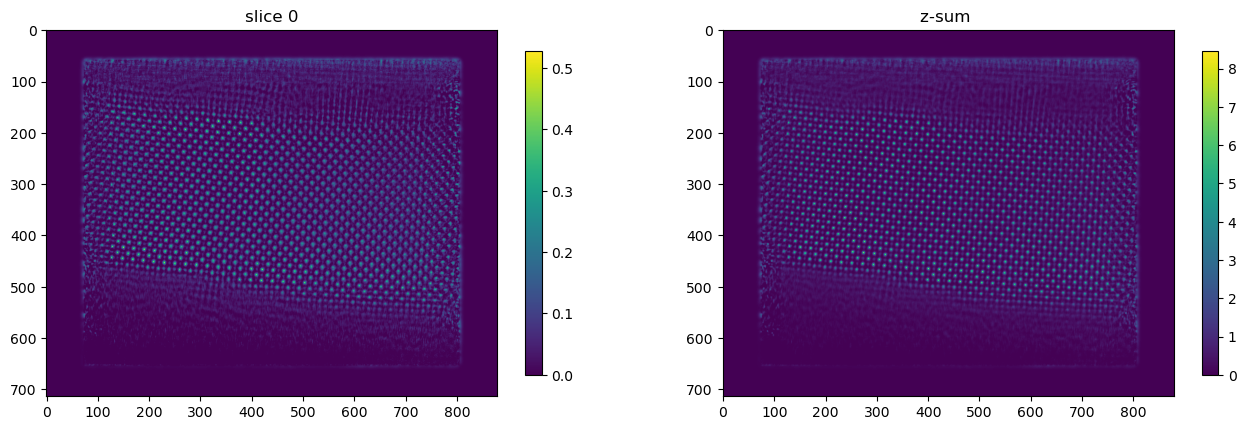

In [2]:
file_path = "output/bSTO/20240515_full_N50688_dp128_random32_p6_plr1e-4_oalr5e-4_oplr5e-4_slr1e-4_tlr0_1obj_13slice_dz10.0_kzreg1_pmk0.61_continue_L1/objp_zstack_iter0100.tif"
dx = 0.1752 # Ang
slice_thickness = 10 # Ang

imstack = imread(file_path)

idx = 0
fig, axs = plt.subplots(1,2, figsize=(16,6))
im0 = axs[0].imshow(imstack[idx])
im1 = axs[1].imshow(imstack.sum(0))

axs[0].set_title(f"slice {idx}")
axs[1].set_title(f"z-sum ")

fig.colorbar(im0, shrink=0.7)
fig.colorbar(im1, shrink=0.7)
plt.show()

In [59]:
# Choose the 2 slices from imstack
slice_t = 5
slice_b = 9
height = (slice_b - slice_t)*slice_thickness
print(f"The height difference between slices {(slice_t, slice_b)} is {height:.2f} Ang")

target_stack = imstack[[slice_t,slice_b]]
blobs = blob_log(target_stack[0], min_sigma=1, max_sigma=5, overlap=0.1, threshold = 0.18, exclude_border=(140,140))
print(f"Found {len(blobs)} blobs with mean radius of {1.414*blobs.mean(0)[-1]:.2f} px or {dx*1.414*blobs.mean(0)[-1]:.2f} Ang")

The height difference between slices (5, 9) is 40.00 Ang
Found 778 blobs with mean radius of 2.12 px or 0.37 Ang


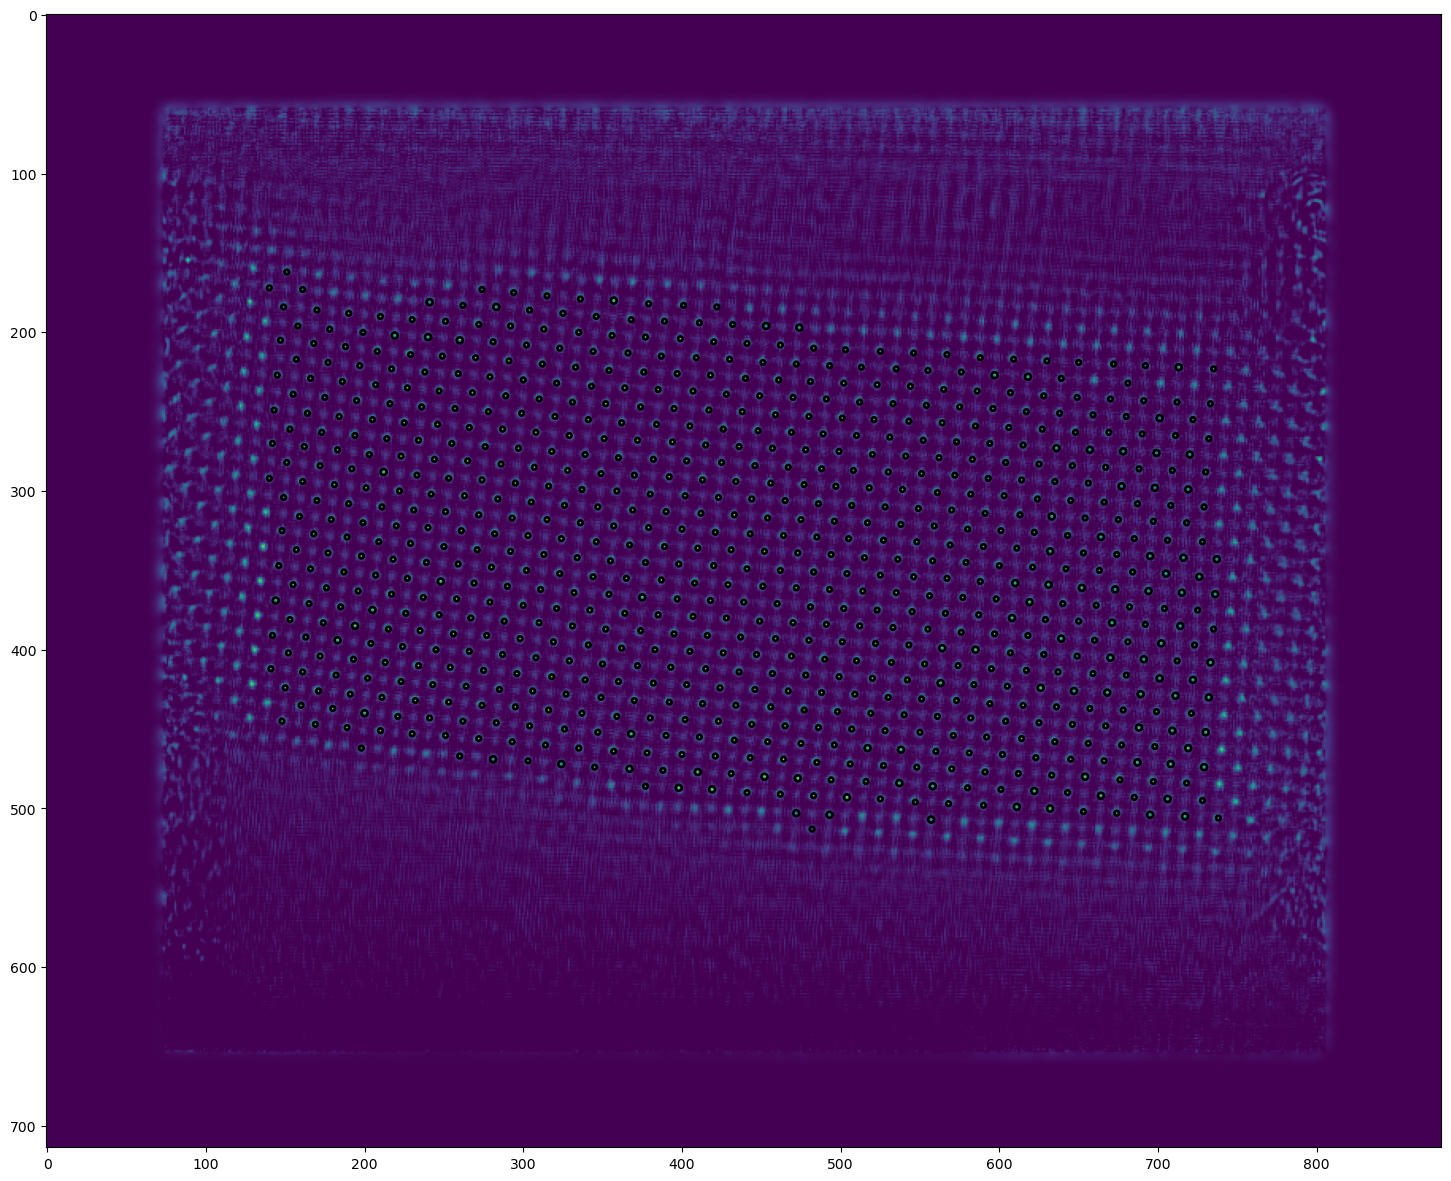

In [63]:
# Plot the detected blobs
fig, ax = plt.subplots(figsize=(18,16))
ax.imshow(target_stack[0])
for blob in blobs:
    y, x, r = blob
    c = plt.Circle((x, y), r, linewidth=2, fill=False)
    ax.add_patch(c)
plt.show()

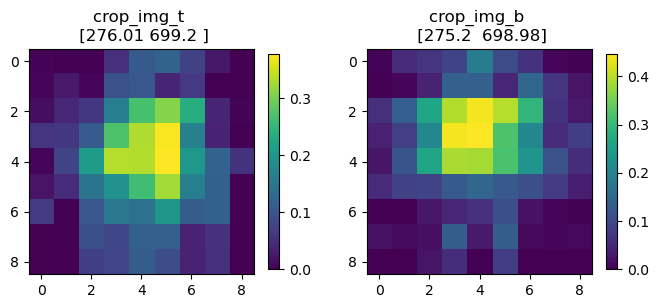

In [64]:
window_size = 9

row_start = np.uint32(blobs[:,0]-window_size//2)
row_end   = np.uint32(blobs[:,0]+window_size//2+1)

col_start = np.uint32(blobs[:,1]-window_size//2)
col_end   = np.uint32(blobs[:,1]+window_size//2+1)

coord_t   = np.zeros((len(blobs),2))
coord_b   = np.zeros((len(blobs),2))

for i in range(len(blobs)):
    crop_img_t = target_stack[0][row_start[i]:row_end[i], col_start[i]:col_end[i]]
    crop_img_b = target_stack[1][row_start[i]:row_end[i], col_start[i]:col_end[i]]
    coord_t[i] = center_of_mass(crop_img_t) + blobs[i,:-1] - window_size//2
    coord_b[i] = center_of_mass(crop_img_b) + blobs[i,:-1] - window_size//2

shift_vecs = coord_b - coord_t # This is the needed tilt to correct the obj tilt so it's pointing from top to bottom

fig, axs = plt.subplots(1,2, figsize=(8,4))
im0 = axs[0].imshow(crop_img_t)
im1 = axs[1].imshow(crop_img_b)

axs[0].set_title(f"crop_img_t \n {coord_t[-1].round(2)}")
axs[1].set_title(f"crop_img_b \n {coord_b[-1].round(2)}")

fig.colorbar(im0, shrink=0.7)
fig.colorbar(im1, shrink=0.7)
plt.show()

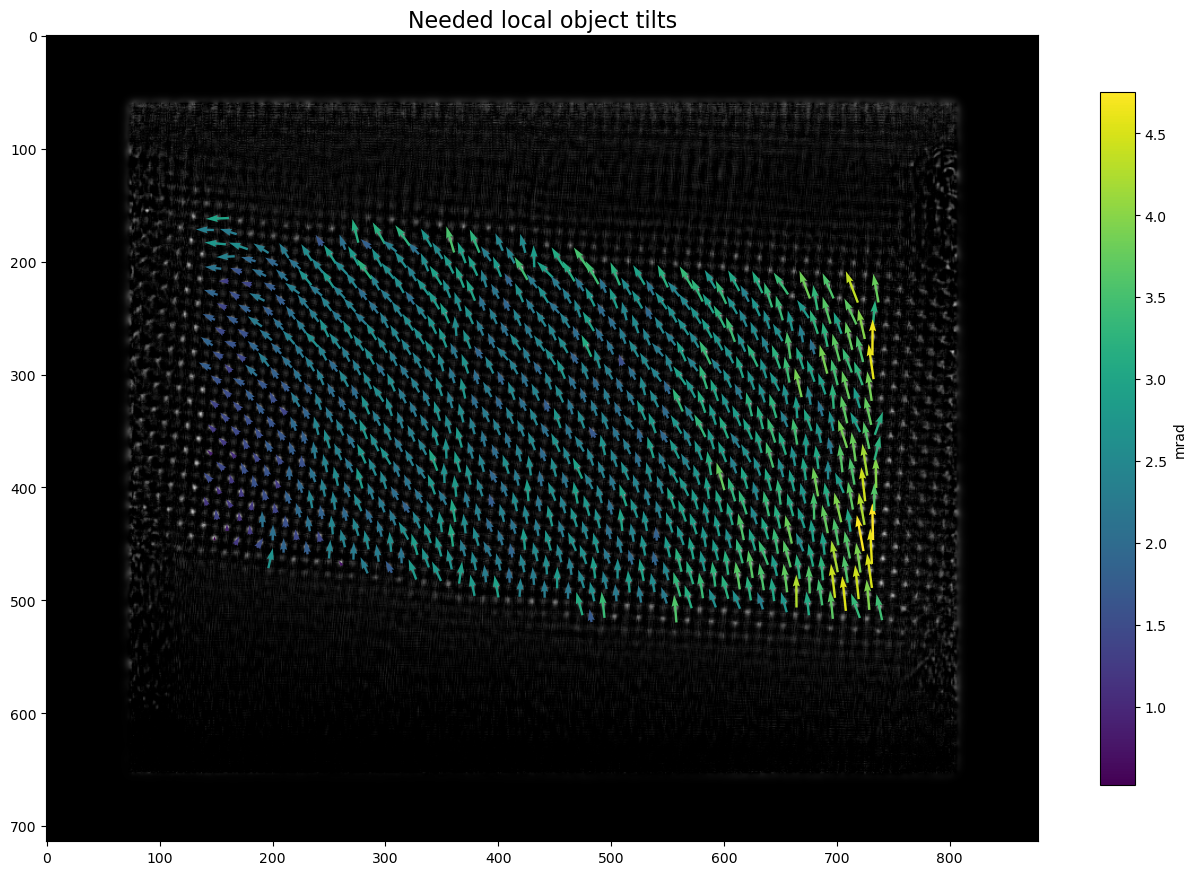

In [66]:
# Plot the tilt vectors
X = coord_t[:,1]
Y = coord_t[:,0]
U = shift_vecs[:,1]
V = shift_vecs[:,0]
M = np.arctan(np.hypot(U,V)*dx/height)*1e3

fig, ax = plt.subplots(figsize=(16,12))
plt.title("Needed local object tilts", fontsize=16)
ax.imshow(target_stack[0], cmap='gray')
q = ax.quiver(X, Y, U, V, M, pivot='mid', angles='xy', scale_units='xy')
cbar = fig.colorbar(q, shrink=0.75)
cbar.ax.set_ylabel('mrad')
plt.show()


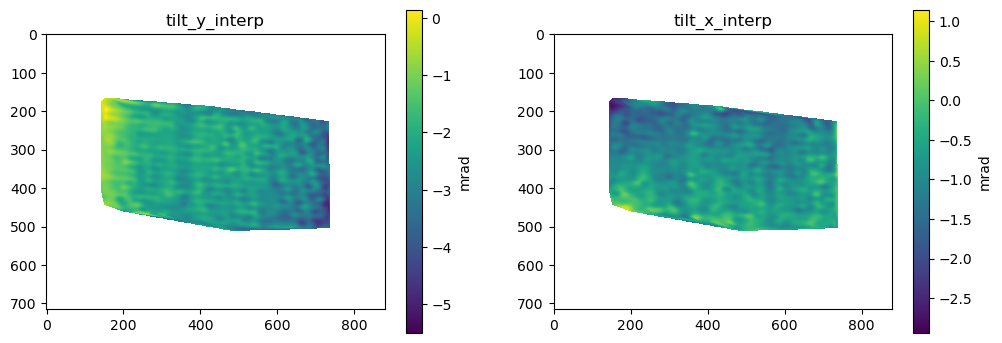

In [67]:
# Do the interpolation with griddata
tilt_y = np.arctan(V*dx/height)*1e3
tilt_x = np.arctan(U*dx/height)*1e3

#Interpolate tilt_y, tilt_x map
xnew, ynew= np.mgrid[0:target_stack.shape[-2]:1, 0:target_stack.shape[-1]:1]
tilt_y_interp = griddata(np.stack([Y,X], -1), tilt_y ,(xnew, ynew), method='cubic')
tilt_x_interp = griddata(np.stack([Y,X], -1), tilt_x ,(xnew, ynew), method='cubic')

fig, axs = plt.subplots(1,2, figsize=(12,6))
im0=axs[0].imshow(tilt_y_interp)
im1=axs[1].imshow(tilt_x_interp)
axs[0].set_title(f"tilt_y_interp")
axs[1].set_title(f"tilt_x_interp")
cbar0 = fig.colorbar(im0, shrink=0.7)
cbar0.ax.set_ylabel('mrad')
cbar1 = fig.colorbar(im1, shrink=0.7)
cbar1.ax.set_ylabel('mrad')
plt.show()

In [68]:
# Use curve_fit to extrapolate to the entire FOV

def surface_fn(t, a1, b1, c1, d):
    y,x = t
    return  a1*x + b1*y + c1*x*y + d

xdata = np.vstack((Y,X))
ydata_tilt_y = tilt_y
ydata_tilt_x = tilt_x
popt_tilt_y, _ = curve_fit(surface_fn, xdata, ydata_tilt_y)
popt_tilt_x, _ = curve_fit(surface_fn, xdata, ydata_tilt_x)

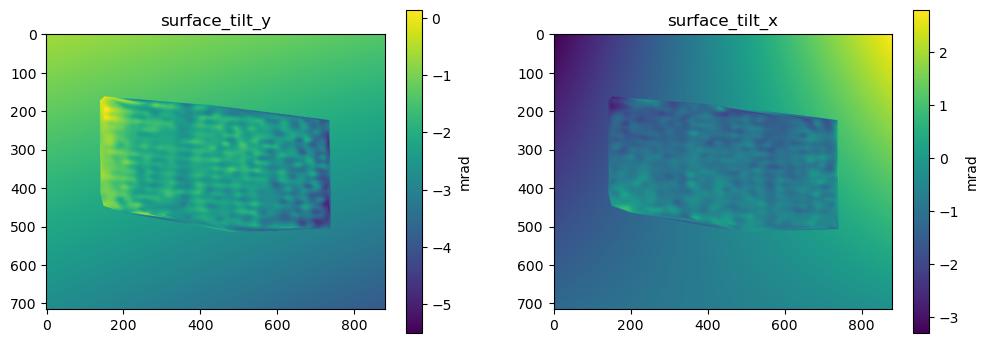

In [69]:
# Implanting griddata interpolated values into the fitted background
surface_tilt_y = surface_fn(np.stack((ynew,xnew)), *popt_tilt_y)
surface_tilt_x = surface_fn(np.stack((ynew,xnew)), *popt_tilt_x)

mask_tilt_y = ~np.isnan(tilt_y_interp)
surface_tilt_y[mask_tilt_y] = tilt_y_interp[mask_tilt_y]
mask_tilt_x = ~np.isnan(tilt_x_interp)
surface_tilt_x[mask_tilt_x] = tilt_x_interp[mask_tilt_x]

fig, axs = plt.subplots(1,2, figsize=(12,6))
im0=axs[0].imshow(surface_tilt_y)
im1=axs[1].imshow(surface_tilt_x)
axs[0].set_title(f"surface_tilt_y")
axs[1].set_title(f"surface_tilt_x")
cbar0 = fig.colorbar(im0, shrink=0.7)
cbar0.ax.set_ylabel('mrad')
cbar1 = fig.colorbar(im1, shrink=0.7)
cbar1.ax.set_ylabel('mrad')
plt.show()

In [70]:
# Load crop_pos from reconstruction

import torch
state_dict = torch.load("output/bSTO/20240515_full_N50688_dp128_random32_p6_plr1e-4_oalr5e-4_oplr5e-4_slr1e-4_tlr0_1obj_13slice_dz10.0_kzreg1_pmk0.61_continue_L1/model_iter0110.pt")
pos = state_dict['model_params']['crop_pos'] + state_dict['exp_params']['Npix']//2
pos = pos.detach().cpu().numpy()
pos

array([[124, 138],
       [126, 138],
       [128, 138],
       ...,
       [586, 742],
       [588, 742],
       [590, 742]], dtype=int16)

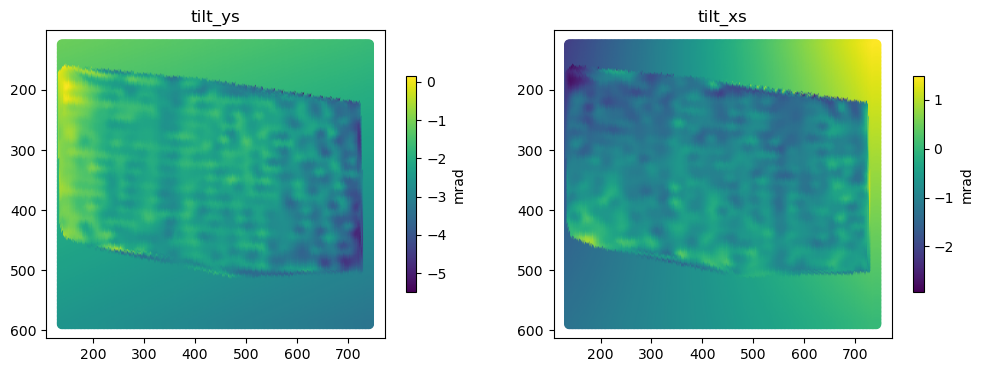

In [71]:
# Sample the surface with our probe position
tilt_ys = surface_tilt_y[pos[:,0], pos[:,1]]
tilt_xs = surface_tilt_x[pos[:,0], pos[:,1]]
obj_tilts = np.stack([tilt_ys, tilt_xs], axis=-1)

fig, axs = plt.subplots(1,2, figsize=(12,4))
im0=axs[0].scatter(x=pos[:,1], y=pos[:,0], c=obj_tilts[:,0])
im1=axs[1].scatter(x=pos[:,1], y=pos[:,0], c=obj_tilts[:,1])
axs[0].invert_yaxis()
axs[1].invert_yaxis()

axs[0].set_title(f"tilt_ys")
axs[1].set_title(f"tilt_xs")
cbar0 = fig.colorbar(im0, shrink=0.7)
cbar0.ax.set_ylabel('mrad')
cbar1 = fig.colorbar(im1, shrink=0.7)
cbar1.ax.set_ylabel('mrad')
plt.show()